In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import nltk
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from matplotlib import rcParams
from nltk.tokenize import RegexpTokenizer
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing the dataset
!wget https://github.com/ngtaylor/EE460J-Final-Project/raw/main/data/training.1600000.processed.noemoticon.csv.zip
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv.zip', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

'wget' is not recognized as an internal or external command,
operable program or batch file.


,target,ids,date,flag,user,text
1050175,4,1960629645,Fri May 29 08:15:43 PDT 2009,NO_QUERY,jimiwes,"@DJFeddeleGrande ahh, Womb, Cocoon and Pacha T..."
523994,0,2193325208,Tue Jun 16 08:18:14 PDT 2009,NO_QUERY,emboosh,jonas brothers &amp; mcfly. it's actually brea...
1413330,4,2056824828,Sat Jun 06 11:51:52 PDT 2009,NO_QUERY,GourmetBen,@joetronico Bet you broke it in Safari though
536757,0,2198522730,Tue Jun 16 16:11:45 PDT 2009,NO_QUERY,datagirl09,@fallingapart apparently I'm off to go workou...
826820,4,1556743102,Sun Apr 19 00:08:04 PDT 2009,NO_QUERY,laurenshmuno,if ya dont knooow now ya knowww sugaaaa


In [3]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [5]:
print('length of data is', len(df))

length of data is 1600000


In [6]:
df.shape

(1600000, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [8]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [9]:
np.sum(df.isnull().any(axis=1))

0

In [10]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [11]:
df['target'].unique()

array([0, 4], dtype=int64)

In [12]:
df['target'].nunique()

2

In [13]:
data=df[['text','target']]
data['target'] = data['target'].replace(4,1)
data['target'].unique()


array([0, 1], dtype=int64)

In [14]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [15]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [16]:
dataset = pd.concat([data_pos, data_neg])

In [17]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [18]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [19]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [20]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [21]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [22]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [23]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [24]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [25]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [26]:
lm = nltk.WordNetLemmatizer()
nltk.download('wordnet')
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mgwit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [27]:
X=data.text
y=data.target

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [29]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [30]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [31]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print('Test set\n Accuracy: {:0.4f}'.format(accuracy_score(y_test, y_pred)))
    fig, ax = plot_confusion_matrix(conf_mat=cf_matrix, figsize = (10,10), 
                                show_absolute=True, 
                                show_normed=True, 
                                colorbar=True)
    

In [32]:
def plot_ROC(y_test, y_pred):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

Test set
 Accuracy: 0.8015


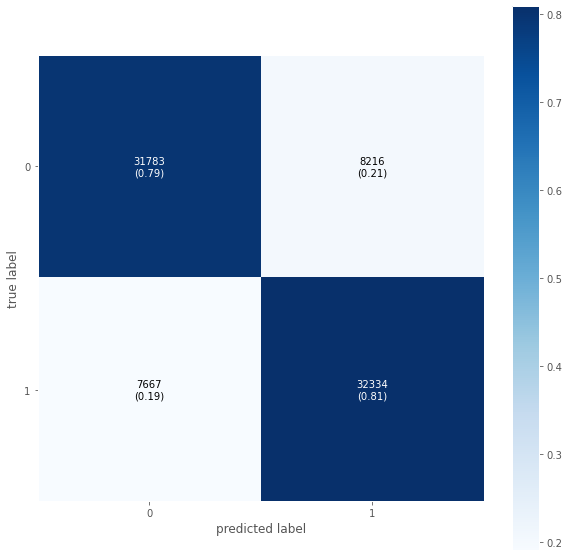

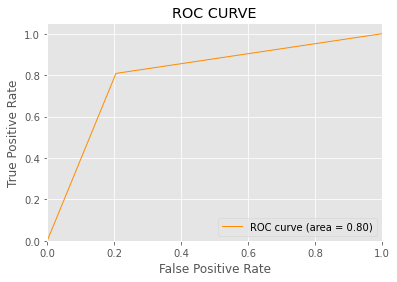

In [33]:
from sklearn.naive_bayes import BernoulliNB
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred = BNBmodel.predict(X_test)
plot_ROC(y_test, y_pred)

Test set
 Accuracy: 0.8265


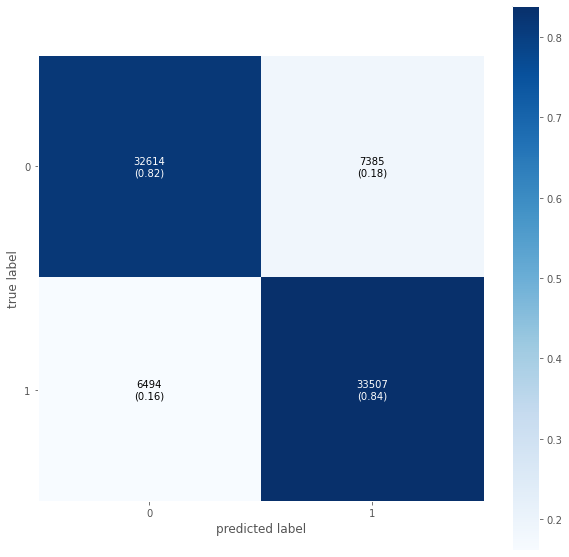

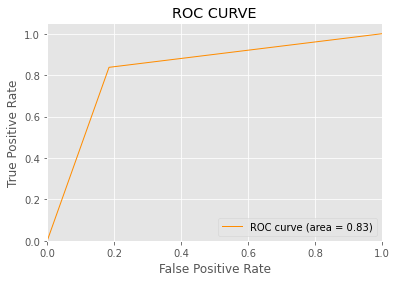

In [34]:
from sklearn.svm import LinearSVC
SVCmodel = LinearSVC(C = 0.1)
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred = SVCmodel.predict(X_test)
plot_ROC(y_test, y_pred)

Test set
 Accuracy: 0.8265


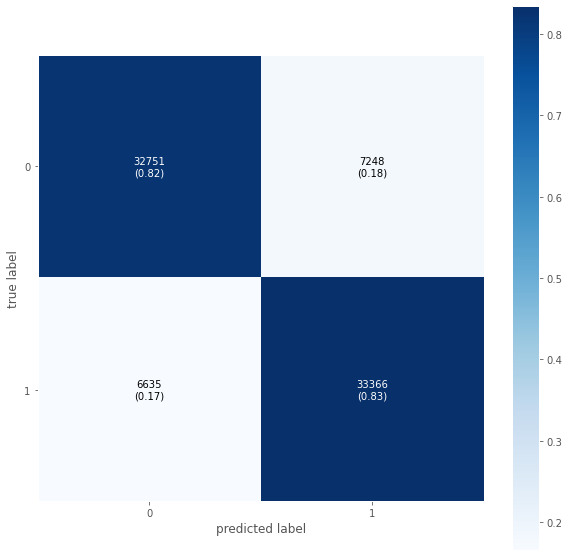

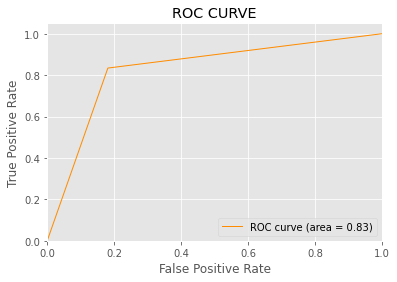

In [35]:
from sklearn.linear_model import LogisticRegression
LRmodel = LogisticRegression(C = 2.875, max_iter = 200, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred = LRmodel.predict(X_test)
plot_ROC(y_test, y_pred)

Test set
 Accuracy: 0.7430


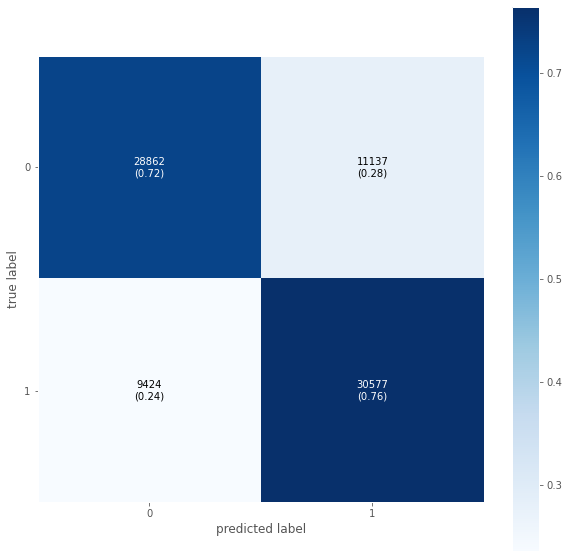

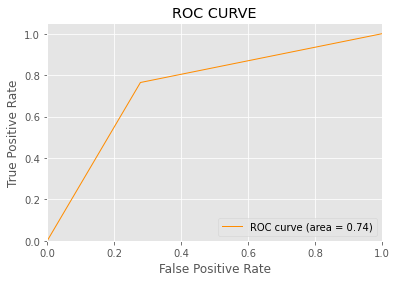

In [36]:
from sklearn.ensemble import RandomForestClassifier
RFmodel = RandomForestClassifier(max_depth=32, n_jobs=-1)
RFmodel.fit(X_train, y_train)
model_Evaluate(RFmodel)
y_pred = RFmodel.predict(X_test)
plot_ROC(y_test, y_pred)

Test set
 Accuracy: 0.7563


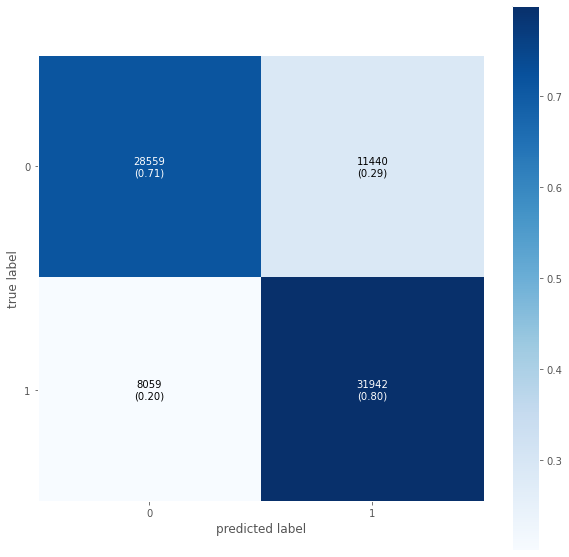

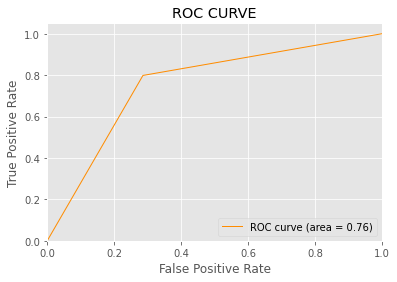

In [37]:
from xgboost import XGBClassifier
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 12,
    "min_child_weight": 0,
    "subsample": 0.8,
    "eta": 0.1
}
XGBmodel = XGBClassifier(**params)
XGBmodel.fit(X_train, y_train)
model_Evaluate(XGBmodel)
y_pred = XGBmodel.predict(X_test)
plot_ROC(y_test, y_pred)